## Introduction

In this notebook, we develop a Fully connected neural network or MLP to classify the pair of questions. We first implement a neural network from scratch including the backpropagation algorithm. We also implement two improved versions of the Gradient descent algorithm namely:
- Momentum based gradient descent
- Nesterov accelerated gradient descent
Following this, we also present a Keras implementation of a FCNN which uses the Adam optimization algorithm with Dropout for regularization.

### Optimization algorithms implemented
- Standard gradient descent:  $\>$  $w(t+1) = w(t) - \eta g_w(t)$
- Momentum based gradient descent: $\>$ $w(t+1) = w(t) - \eta g_w(t) + \alpha \Delta w(t-1)$
- Nesterov accelerated gradient descent: $\>$ $w(t+1) = w(t) - \eta g_w(t+1) + \alpha \Delta w(t-1)$

### Model input
GLoVe vectors corresponding to the words of each question are first obtained and then summed together to get a vector representation for the question. The vectors correspoding to the 2 questions are concatenated and given as input to the model.

### Model architecture
The FCNN consists of an input layer of size 2*(GLoVe embedding dimension) due to vector concatenation. This is followed by 3 hidden layers. Experiments have been conducted by varying the sizes of these hidden layers as well. Dropout is added between the layers in the Keras implementation for regularization. 

### Model output
- 1 - represents a duplicate pair
- 0 - represents a non-duplicate pair

In [18]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from nltk.tokenize import word_tokenize
import pandas as pd
import string
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split 
from pylab import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Data pre-processing and conversion of words into GLoVe vectors

# Parameters
GLOVE_EMBED  = 300
MAX_QUESTION_LENGTH = 30

prefix = '/content/drive/My Drive/Quora Questions Project/' 
lemmatizer = WordNetLemmatizer() 
data = pd.read_csv(prefix+"questions.csv")
data = data.dropna() # Remove null values
data = data.drop(['id','qid1','qid2'],axis=1)
g = data.groupby('is_duplicate', group_keys=False)
# data = g.apply(lambda x: x.sample(g.size().min()).reset_index()).sample(frac=0.5)
data = column_stack((data.question1,data.question2,data.is_duplicate))
train_data, test_data = train_test_split(data, test_size= 0.15)
embeddings_index = {}
f = open(prefix+'glove.6B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vectors representing the embedding for the word
    embeddings_index[word] = coefs
f.close() 
def preProcess(doc):
    processed = []
    for i in range(2):
        doc_processed = (doc[i]).lower()
        translator = str.maketrans('','',string.punctuation)
        doc_processed = doc_processed.translate(translator)
        doc_processed = word_tokenize(doc_processed)
        if len(doc_processed)>MAX_QUESTION_LENGTH: # Restrict question size to 80 words
            return []
        #doc_processed = [lemmatizer.lemmatize(w) for w in doc_processed]
        vect = []
        for word in doc_processed:
            if word in embeddings_index:
                vect.append(embeddings_index[word])
            else:
                vect.append(np.zeros(GLOVE_EMBED))
        vect.extend([np.zeros(GLOVE_EMBED)]*(MAX_QUESTION_LENGTH-len(vect)))
        processed.append(vect)
        #processed.extend([np.zeros(GLOVE_EMBED)]*(MAX_QUESTION_LENGTH-len(vect)))
    processed.append(doc[2])
    return processed

print(train_data[0,:])
# print(preProcess(train_data[0,:]))  

['What is the corporate culture like at Liquidity Service? How is the culture different than other companies?'
 'What is the corporate culture like at H&E Equipment Services? How is the culture different than other companies?'
 0]


In [0]:
# Creating the training set
train_vecs = []
for i in range(len(train_data)):
    train_vecs.append(preProcess(train_data[i,:])) 
train_vecs = [x for x in train_vecs if x] # remove all empty lists

# Preparing data for passing into FCNN
X_train_1 = np.zeros((len(train_vecs), GLOVE_EMBED))
X_train_2 = np.zeros((len(train_vecs), GLOVE_EMBED))
y_train = np.zeros((len(train_vecs), 1))

for i in range(len(train_vecs)):
    X_train_1[i] = np.sum(np.array(train_vecs[i][0]), axis=0)
    X_train_2[i] = np.sum(np.array(train_vecs[i][1]), axis=0)
    y_train[i] = train_vecs[i][2]

In [0]:
# Creating the test set
test_vecs = []
for i in range(len(test_data)):
    test_vecs.append(preProcess(test_data[i,:])) 
test_vecs = [x for x in test_vecs if x] # remove all empty lists

# Preparing data for passing into keras model
X_test_1 = np.zeros((len(test_vecs), GLOVE_EMBED))
X_test_2 = np.zeros((len(test_vecs), GLOVE_EMBED))
y_test = np.zeros((len(test_vecs), 1))

for i in range(len(test_vecs)):
    X_test_1[i] = np.sum(np.array(test_vecs[i][0]), axis=0)
    X_test_2[i] = np.sum(np.array(test_vecs[i][1]), axis=0)
    y_test[i] = test_vecs[i][2] 

In [0]:
X_train = np.concatenate([X_train_1, X_train_2], axis=1)
X_test = np.concatenate([X_test_1, X_test_2], axis=1)

#### Hidden layer details
For this implementation, we set the hidden layer sizes to 40, 20 and 10 for the following reasons:
- The implemented model does not use GPU-optimized parallel computation and is therefore, slower to train. So, we need to restrict the number of training samples.
- This means the number of parameters in the model should also be small.

        Number of paramters (excl. bias terms)  = 600 * 40 + 40 * 20 + 20 * 10 + 10 * 1 = 25010 parameters

- The  number of training samples should at least be larger than this number to prevent shattering.
- A model with smaller hidden layer sizes may have less representation power, but can be trained with a smaller number of training samples without overfitting.
- Later, we use a faster Keras implementation with Dropout regularization where we use larger hidden layer sizes.

In [0]:
# Parameter declarations

IN_SIZE = 2*GLOVE_EMBED # We concatenate both questions and pass it as input to the model, so length is twice
OUT_SIZE = 1
NUM_EPOCHS = 40
batch_size = 1
lr = 0.05 
momentum = 0.3
num_hidden = 3
sizes = [40,20,10]
activation = 'sigmoid'
batch_size = 1 
size_list = [IN_SIZE] + sizes + [OUT_SIZE]
np.random.seed(1234)

In [0]:
# Useful function definitions
def sigmoid(m):
    return (1/(1+np.exp(-m)))  # This is a vectorized function

def tanh(m):
    return (np.exp(m)-np.exp(-m))/(np.exp(m)+np.exp(-m))

def softmax(m):
    return (np.exp(m-np.max(m))/np.sum(np.exp(m-np.max(m))))

def sigmoid_derivative(m):
    return sigmoid(m)*(1-sigmoid(m))

def tanh_derivative(m):
    return 1-tanh(m)*tanh(m) 

In [0]:
def forward_prop(weights_list, bias_list, inputs, exp_outputs):
    """ Forward propagation function """
    pre_act_list =[0]*(num_hidden+2)
    post_act_list = [0]*(num_hidden+2)
    post_act_list[0] = inputs
    if activation=='sigmoid':
        act = sigmoid
    if activation=='tanh':
        act=tanh
    for k in range(1, num_hidden+1):
        pre_act_list[k] = np.dot(weights_list[k],post_act_list[k-1])+bias_list[k]
        post_act_list[k] = act(pre_act_list[k])

    pre_act_list[num_hidden+1] = np.dot(weights_list[num_hidden+1],post_act_list[num_hidden])+bias_list[num_hidden+1]
    outputs = pre_act_list[num_hidden+1]
    loss = 0.5*(exp_outputs-outputs[0])**2
    return pre_act_list, post_act_list, outputs, loss 

In [0]:
def backward_prop(weights_list, pre_act_list, post_act_list, outputs, exp_output_val):
    """ Backpropagation algorithm implementation """
    if(activation=='sigmoid'):
        fn = sigmoid_derivative
    elif activation=='tanh':
        fn = tanh_derivative
    else:
        print("Activation function is invalid!")

    grad_ak_list = [0]*(num_hidden+2) #1st element of these lists are dummy values
    grad_hk_list = [0]*(num_hidden+2)
    grad_wk_list = [0]*(num_hidden+2)
    grad_bk_list = [0]*(num_hidden+2)
    grad_ak_list[num_hidden+1] = -(exp_output_val - outputs)
    for k in range(num_hidden+1, 0, -1):
        # Compute gradients w.r.t parameters
        grad_wk_list[k] = np.dot(np.expand_dims(grad_ak_list[k],axis=1), np.transpose(np.expand_dims(post_act_list[k-1],axis=1)))
        grad_bk_list[k] = grad_ak_list[k].copy()
        # Compute gradients w.r.t layer below
        grad_hk_list[k-1] = np.dot(np.transpose(weights_list[k]), grad_ak_list[k])
        # Compute gradients w.r.t layer below (pre-activation)
        grad_ak_list[k-1] = grad_hk_list[k-1]*fn(pre_act_list[k-1])        
    return grad_wk_list, grad_bk_list 

In [0]:
def predict(weights_list, bias_list, inputs, exp_outputs, verbatim=False):
    """ Function for finding loss during evaluation """
    val_loss = 0
    output_list = []
    corr = 0
    for i in range(len(inputs)):
        pre_act_list, post_act_list, outputs, loss = forward_prop(weights_list, bias_list, inputs[i], exp_outputs[i])
        val_loss+=loss
        outputs = np.round(outputs)
        output_list.append(outputs)
        if(exp_outputs[i]==outputs):
            corr+=1
    val_loss = val_loss/len(inputs)
    acc = corr/len(inputs)
    return val_loss, acc, output_list  

In [0]:
def momentum_gradient_descent(batch_size, lr, momentum, train_inputs, train_label, validation_inputs, validation_label,actual_Y_train):
    "Function for performing momentum-based Gradient descent"
    val_loss = 100000000 #Dummy 
    train_loss = 100000000 #Dummy
    train_loss_list=[]
    val_loss_list = []
    weights_list = []
    bias_list = []
    prev_grad_weights_list = []
    prev_grad_bias_list = []
    # Initialize weights and biases
    for i in range(0, num_hidden+2):
        weights_list.append(np.random.randn(size_list[i], size_list[i-1])) #weights & biases at index 0 are just dummy values
        bias_list.append(np.random.randn(size_list[i])) 
        prev_grad_weights_list.append(np.zeros((size_list[i], size_list[i-1])))
        prev_grad_bias_list.append(np.zeros(size_list[i]))
    
    for epoch in range(NUM_EPOCHS):
        num_points_seen = 0
        cum_loss = 0
        for sample in range(TRAIN_SIZE):
            # Forward prop
            pre_act_list, post_act_list, outputs, loss = forward_prop(weights_list, bias_list, train_inputs[sample], train_label[sample])
            # Backward prop
            grad_wk_list, grad_bk_list = backward_prop(weights_list, pre_act_list, post_act_list, outputs, train_label[sample]) 
            cum_loss += loss
            if(num_points_seen==0):
                grad_wk_to_update = grad_wk_list.copy()
                grad_bk_to_update = grad_bk_list.copy()
            else:
                grad_wk_to_update = [sum(x) for x in zip(grad_wk_to_update, grad_wk_list)]
                grad_bk_to_update = [sum(x) for x in zip(grad_bk_to_update, grad_bk_list)]
            num_points_seen+=1
            
            if (num_points_seen % batch_size == 0):
                curr_weights_update_list = (num_hidden+2)*[0]
                curr_bias_update_list = (num_hidden+2)*[0]
                for i in range(len(weights_list)):
                    curr_weights_update_list[i] = momentum*(prev_grad_weights_list[i])+lr*(grad_wk_to_update[i]/batch_size)
                    curr_bias_update_list[i] = momentum*(prev_grad_bias_list[i])+lr*(grad_bk_to_update[i]/batch_size)
                    weights_list[i] = weights_list[i] - curr_weights_update_list[i]
                    bias_list[i] = bias_list[i] - curr_bias_update_list[i]

                prev_grad_weights_list = curr_weights_update_list.copy()
                prev_grad_bias_list = curr_bias_update_list.copy()

                num_points_seen = 0
                # steps += 1
        val_loss_old = val_loss
        train_loss_old = train_loss
        # Evaluate performance after each epoch
        train_loss,train_acc,_ = predict(weights_list, bias_list, train_inputs, actual_Y_train)
        val_loss,val_acc,_ = predict(weights_list, bias_list, validation_inputs, validation_label)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        print("Epoch {}, Train loss {}, Train accuracy {}, Validation loss {}, Validation acc {}".format(epoch, train_loss, np.round(train_acc,4), val_loss, np.round(val_acc,4)))
        # Stopping condition
        # if train_loss_old-train_loss<0.0006:
        #     break
    
    return weights_list, bias_list, train_loss_list, val_loss_list 

In [0]:
def NAG(batch_size, lr, momentum, train_inputs, train_label, validation_inputs, validation_label, actual_Y_train):
    
    "Function for performing Nesterov's accelerated Gradient descent"
    TRAIN_SIZE = len(train_inputs)
    VALID_SIZE = len(validation_inputs)
    val_loss = 100000000 #Dummy 
    train_loss = 100000000 #Dummy
    train_loss_list=[]
    val_loss_list = []
    weights_list = []
    bias_list = []
    prev_grad_weights_list = []
    prev_grad_bias_list = []
    weights_lookahead_list = (num_hidden+2)*[0]
    for i in range(0, num_hidden+2):
        weights_list.append(np.random.randn(size_list[i], size_list[i-1])) #weights & biases at index 0 are just dummy values
        bias_list.append(np.random.randn(size_list[i])) 
        prev_grad_weights_list.append(np.zeros((size_list[i], size_list[i-1])))
        prev_grad_bias_list.append(np.zeros(size_list[i]))
    

    for epoch in range(NUM_EPOCHS):
        num_points_seen = 0
        cum_loss = 0
        for sample in range(TRAIN_SIZE):
            pre_act_list, post_act_list, outputs, loss = forward_prop(weights_list, bias_list, train_inputs[sample], train_label[sample])
            
            for i in range(len(weights_list)):
                weights_lookahead_list[i] = weights_list[i]-momentum*(prev_grad_weights_list[i]) 
            
            grad_wk_list, grad_bk_list = backward_prop(weights_lookahead_list, pre_act_list, post_act_list, outputs, train_label[sample]) 

            if(num_points_seen==0):
                grad_wk_to_update = grad_wk_list.copy()
                grad_bk_to_update = grad_bk_list.copy()
            else:
                grad_wk_to_update = [sum(x) for x in zip(grad_wk_to_update, grad_wk_list)]
                grad_bk_to_update = [sum(x) for x in zip(grad_bk_to_update, grad_bk_list)]
            num_points_seen+=1
            
            if (num_points_seen % batch_size == 0):
                curr_weights_update_list = (num_hidden+2)*[0]
                curr_bias_update_list = (num_hidden+2)*[0]
                for i in range(len(weights_list)):
                    curr_weights_update_list[i] = momentum*(prev_grad_weights_list[i])+lr*(grad_wk_to_update[i]/batch_size)
                    curr_bias_update_list[i] = momentum*(prev_grad_bias_list[i])+lr*(grad_bk_to_update[i]/batch_size)
                    weights_list[i] = weights_list[i] - curr_weights_update_list[i]
                    bias_list[i] = bias_list[i] - curr_bias_update_list[i]
                prev_grad_weights_list = curr_weights_update_list.copy()
                prev_grad_bias_list = curr_bias_update_list.copy()

                num_points_seen = 0
                
        val_loss_old = val_loss
        train_loss_old = train_loss
        # Evaluate performance after each epoch
        train_loss,train_acc,_ = predict(weights_list, bias_list, train_inputs, actual_Y_train)
        val_loss,val_acc,_ = predict(weights_list, bias_list, validation_inputs, validation_label)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        print("Epoch {}, Train loss {}, Train accuracy {}, Validation loss {}, Validation acc {}".format(epoch, train_loss, np.round(train_acc,4), val_loss, np.round(val_acc,4)))
        # Stopping condition
        # if train_loss_old-train_loss<0.0006:
        #     break

    return weights_list, bias_list, train_loss_list, val_loss_list  

In [46]:
# Nesterov accelerated gradient descent (NAG) - without output rounding
# Due to slower training, we use only a subset of the training and validation data for this case
weights_list_updated, bias_list_updated, train_loss_list, val_loss_list = NAG(batch_size, lr, momentum,
                                                                    X_train[:30000], y_train[:30000], X_test[:5000], y_test[:5000], y_train[:30000]) 

Epoch 0, Train loss [0.11392364], Train accuracy 0.6293, Validation loss [0.11319773], Validation acc 0.6362
Epoch 1, Train loss [0.11257427], Train accuracy 0.6334, Validation loss [0.11249623], Validation acc 0.6312
Epoch 2, Train loss [0.11129951], Train accuracy 0.644, Validation loss [0.11143119], Validation acc 0.635
Epoch 3, Train loss [0.10973895], Train accuracy 0.6469, Validation loss [0.11016384], Validation acc 0.6486
Epoch 4, Train loss [0.10937375], Train accuracy 0.6513, Validation loss [0.11012785], Validation acc 0.6576
Epoch 5, Train loss [0.10841432], Train accuracy 0.6567, Validation loss [0.10962858], Validation acc 0.653
Epoch 6, Train loss [0.10686732], Train accuracy 0.6639, Validation loss [0.10815117], Validation acc 0.6566
Epoch 7, Train loss [0.10727432], Train accuracy 0.6621, Validation loss [0.10888533], Validation acc 0.6596
Epoch 8, Train loss [0.1056587], Train accuracy 0.672, Validation loss [0.10821731], Validation acc 0.6588
Epoch 9, Train loss [0.1

In [47]:
test_loss,test_acc,_ = predict(weights_list_updated, bias_list_updated, X_test, y_test)
print("Test Loss = {}, Test Accuracy = {}".format(test_loss,test_acc))

Test Loss = [0.10372421], Test Accuracy = 0.6880666049953746


In [0]:
# Save weights
np.save('/content/drive/My Drive/Quora Questions Project/wts_qqp', weights_list_updated)
np.save('/content/drive/My Drive/Quora Questions Project/bias_qqp', bias_list_updated)  

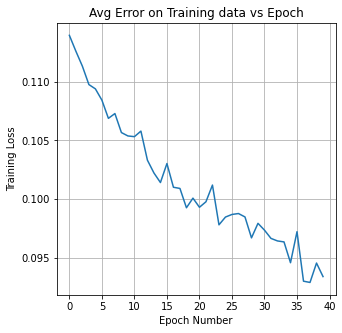

In [49]:
# Average error vs epoch plot

plt.figure(figsize = (5,5))
plt.plot(np.array(train_loss_list[:]))
plt.xlabel("Epoch Number")
plt.ylabel("Training Loss")
plt.grid(True)
plt.title("Avg Error on Training data vs Epoch") 
plt.show()

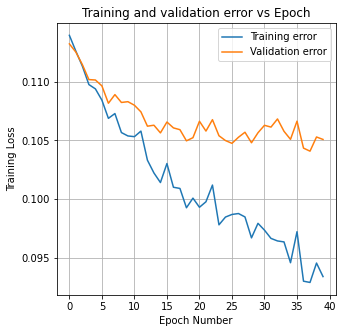

In [50]:
# Loss vs epoch plot
plt.figure(figsize = (5,5))
plt.plot(np.array(train_loss_list),label='Training error')
plt.plot(np.array(val_loss_list), label = 'Validation error')
plt.xlabel("Epoch Number")
plt.ylabel("Training Loss")
plt.grid(True)
plt.title("Training and validation error vs Epoch") 
plt.legend()
plt.show()

## Keras implementation

#### Model details
- 3 hidden layers - each of size 300
- Learning rate = 0.001
- Sigmoid activation for all layers
- Adam algorithm for training

In [11]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Lambda, Reshape, add, dot, Activation, LSTM, GRU, Bidirectional,\
RepeatVector, Concatenate, Dot, Subtract, TimeDistributed, Multiply, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam, RMSprop
import keras.backend as K

Using TensorFlow backend.


#### Model without dropout

In [13]:
qs_input = Input(shape = (2*GLOVE_EMBED,))
dense_1 = Dense(150, activation='sigmoid')(qs_input)
dense_2 = Dense(75, activation='sigmoid')(dense_1)
dense_3 = Dense(30, activation='sigmoid')(dense_2)
output = Dense(1, activation='sigmoid')(dense_3)

model_no_dropout = Model(qs_input, output)
model_no_dropout.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy']) 
r_no_dropout = model_no_dropout.fit(X_train, y_train, batch_size = 1000, epochs=40, validation_split=0.2) # dropouts 0.3

Train on 269656 samples, validate on 67414 samples
Epoch 1/40
269656/269656 [==============================] - 5s 18us/step - loss: 0.6272 - accuracy: 0.6517 - val_loss: 0.5755 - val_accuracy: 0.7002
Epoch 2/40
269656/269656 [==============================] - 5s 17us/step - loss: 0.5468 - accuracy: 0.7190 - val_loss: 0.5226 - val_accuracy: 0.7325
Epoch 3/40
269656/269656 [==============================] - 5s 17us/step - loss: 0.4951 - accuracy: 0.7511 - val_loss: 0.4920 - val_accuracy: 0.7530
Epoch 4/40
269656/269656 [==============================] - 5s 17us/step - loss: 0.4610 - accuracy: 0.7721 - val_loss: 0.4766 - val_accuracy: 0.7608
Epoch 5/40
269656/269656 [==============================] - 5s 17us/step - loss: 0.4394 - accuracy: 0.7860 - val_loss: 0.4601 - val_accuracy: 0.7730
Epoch 6/40
269656/269656 [==============================] - 5s 17us/step - loss: 0.4219 - accuracy: 0.7975 - val_loss: 0.4547 - val_accuracy: 0.7753
Epoch 7/40
269656/269656 [=============================

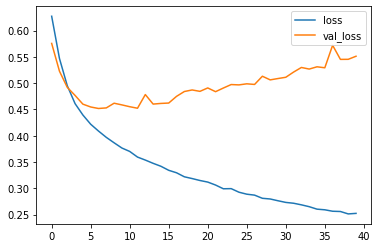

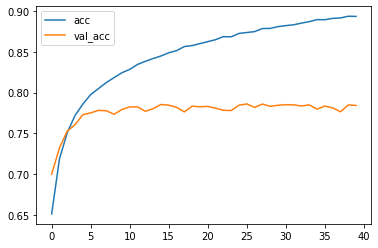

In [14]:
# Loss
plt.plot(r_no_dropout.history['loss'], label='loss')
plt.plot(r_no_dropout.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r_no_dropout.history['accuracy'], label='acc')
plt.plot(r_no_dropout.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show() 

We notice that the validation loss increasing with training epochs in this model, while the training accuracy continuously decreases. This is a clear case of overfitting. 



In [16]:
y_preds = model.predict(X_test)
crr=0
thresh = 0.5
for i in range(len(y_preds)):
    if y_preds[i]>=thresh:
        if y_test[i]==1:
            crr+=1
    else:
        if y_test[i]==0:
            crr+=1
print("Accuracy = {}%".format(100*np.round(crr/len(y_preds),4)))

Accuracy = 70.08%


#### Regularization using dropout

We resolve the issue of overfitting with dropout which is a method of ignoring a random selection of nodes in a hidden layer in each mini-batch during the training process. So, effectively the model learns to predict the output even in the absence of a part of the input data.

In [0]:
qs_input = Input(shape = (2*GLOVE_EMBED,))
dense_1 = Dense(150, activation='sigmoid')(qs_input)
dense_1 = Dropout(0.1)(dense_1)
dense_2 = Dense(75, activation='sigmoid')(dense_1)
dense_2 = Dropout(0.1)(dense_2)
dense_3 = Dense(30, activation='sigmoid')(dense_2)
dense_3 = Dropout(0.1)(dense_3)
output = Dense(1, activation='sigmoid')(dense_3)

model = Model(qs_input, output) 

In [0]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy']) 

In [165]:
r = model.fit(X_train, y_train, batch_size = 1000, epochs=70, validation_split=0.2) #dropouts 0.3

Train on 269651 samples, validate on 67413 samples
Epoch 1/70
269651/269651 [==============================] - 6s 22us/step - loss: 0.6161 - accuracy: 0.6634 - val_loss: 0.5651 - val_accuracy: 0.7108
Epoch 2/70
269651/269651 [==============================] - 6s 22us/step - loss: 0.5453 - accuracy: 0.7197 - val_loss: 0.5199 - val_accuracy: 0.7353
Epoch 3/70
269651/269651 [==============================] - 6s 22us/step - loss: 0.5081 - accuracy: 0.7429 - val_loss: 0.4959 - val_accuracy: 0.7480
Epoch 4/70
269651/269651 [==============================] - 6s 22us/step - loss: 0.4839 - accuracy: 0.7578 - val_loss: 0.4762 - val_accuracy: 0.7603
Epoch 5/70
269651/269651 [==============================] - 6s 22us/step - loss: 0.4685 - accuracy: 0.7668 - val_loss: 0.4719 - val_accuracy: 0.7611
Epoch 6/70
269651/269651 [==============================] - 6s 22us/step - loss: 0.4544 - accuracy: 0.7759 - val_loss: 0.4650 - val_accuracy: 0.7674
Epoch 7/70
269651/269651 [=============================

In [0]:
model.save_weights('/content/drive/My Drive/Quora Questions Project/qqpairs_fcnn.h5') 

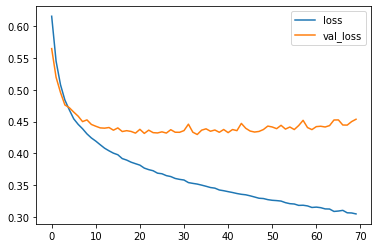

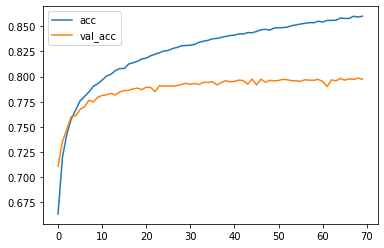

In [170]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show() 

We observe that there is no noticeable increase in the validation loss as the number of training epochs increases. This is due to regularization using Dropout. As seen below, the test accuracy has also improved as a result.

In [183]:
y_preds = model.predict(X_test)
crr=0
thresh = 0.49
for i in range(len(y_preds)):
    if y_preds[i]>=thresh:
        if y_test[i]==1:
            crr+=1
    else:
        if y_test[i]==0:
            crr+=1
print("Accuracy = {}%".format(100*np.round(crr/len(y_preds),4)))

Accuracy = 79.67%


### **Final Model details**

- 3 hidden layers - each of size 300
- Dropout = 0.1
- Learning rate = 0.001
- Sigmoid activation for all layers
- Adam algorithm for training

### **Final model accuracies**
- Training accuracy = 86.01%
- Test accuracy = 79.67%
